#ML MODEL

STEP 1 : LOAD AND PREPARE DATASET

In [145]:
# IMPORT PANDAS FOR DATA HANDLING
import pandas as pd

# LOAD THE CSV FILE INTO A DATAFRAME
DF = pd.read_csv("/content/data - Copy.csv")

# PRINT THE COLUMN NAMES TO VERIFY DATA LOADING
print("COLUMNS IN CSV:", DF.columns.tolist())

COLUMNS IN CSV: ['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern', 'nozzle_temperature', 'bed_temperature', 'print_speed', 'material', 'fan_speed', 'roughness', 'tension_strenght', 'elongation']


STEP 2 : ENCODE CATEGORICAL FEATURES

In [146]:
# APPLY ONE-HOT ENCODING TO 'infill_pattern' AND 'material' COLUMNS
DF_ENCODED = pd.get_dummies(DF, columns=["infill_pattern", "material"], drop_first=True)


 STEP 3 : DEFINE FEATURES AND TARGETS

In [147]:
TARGETS = ["roughness", "tension_strenght", "elongation"]

# FEATURES INCLUDE ALL COLUMNS EXCEPT THE TARGETS
X = DF_ENCODED.drop(columns=TARGETS)

# TARGET OUTPUTS
Y = DF_ENCODED[TARGETS]

# SAVE THE ORDER OF FEATURE COLUMNS FOR INFERENCE
import joblib
joblib.dump(X.columns.tolist(), "/content/feature_columns.pkl")


['/content/feature_columns.pkl']

STEP 4 : SPLIT DATA INTO TRAINING AND TESTING

In [148]:
from sklearn.model_selection import train_test_split

# SPLIT THE DATA INTO TRAINING AND TEST SETS
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.2, random_state=42)


STEP 5 : SCALE THE FEATURES

In [149]:

# IMPORT STANDARD SCALER
from sklearn.preprocessing import StandardScaler

# INITIALIZE THE SCALER
SCALER = StandardScaler()

# FIT AND TRANSFORM THE TRAINING DATA
X_TRAIN_SCALED = SCALER.fit_transform(X_TRAIN)

# TRANSFORM THE TEST DATA USING THE SAME SCALER
X_TEST_SCALED = SCALER.transform(X_TEST)


STEP 6 : TRAIN THE MULTI-OUTPUT MODEL

In [150]:
# IMPORT LINEAR REGRESSION MODEL
from sklearn.linear_model import LinearRegression

# INITIALIZE THE LINEAR REGRESSION MODEL
MODEL = LinearRegression()

# TRAIN THE MODEL WITH THE SCALED TRAINING DATA
MODEL.fit(X_TRAIN_SCALED, Y_TRAIN)


LinearRegression()

STEP 7 : EVALUATE MODEL PERFORMANCE USING SCATTER PLOTS

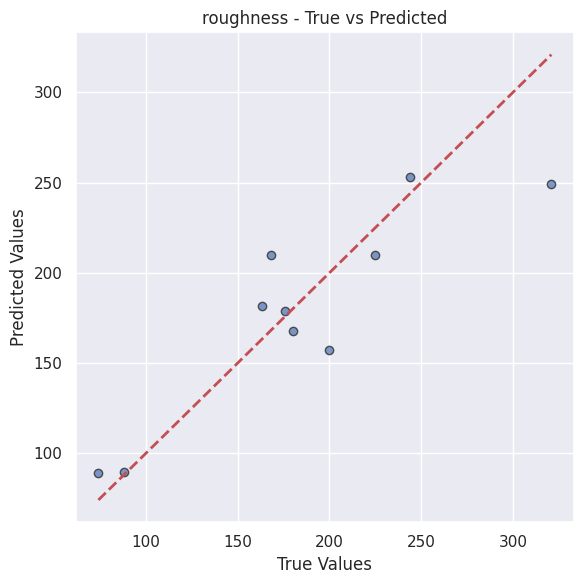

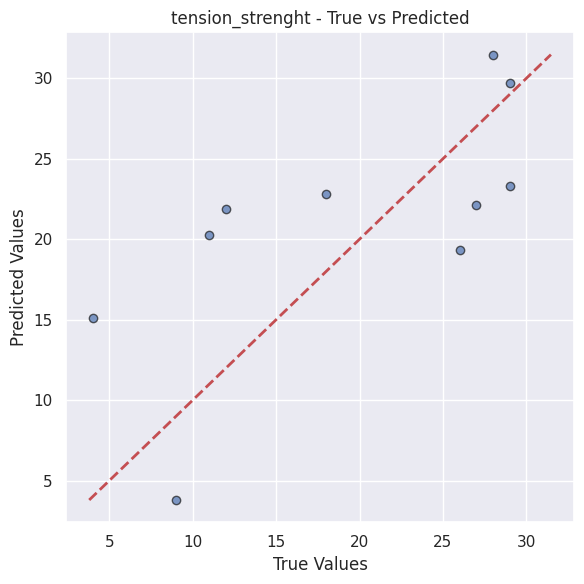

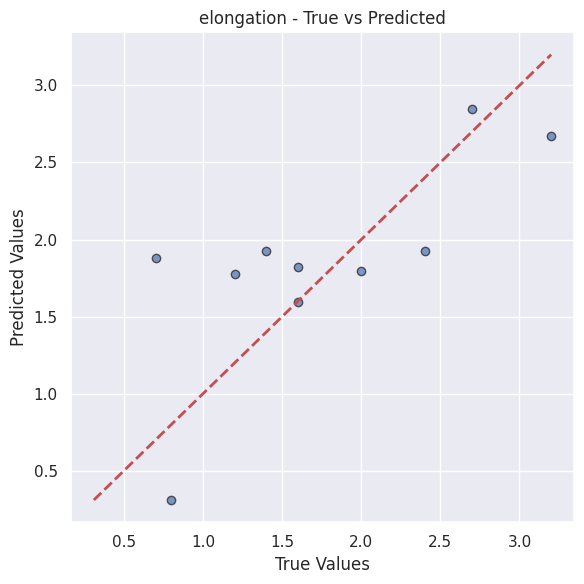

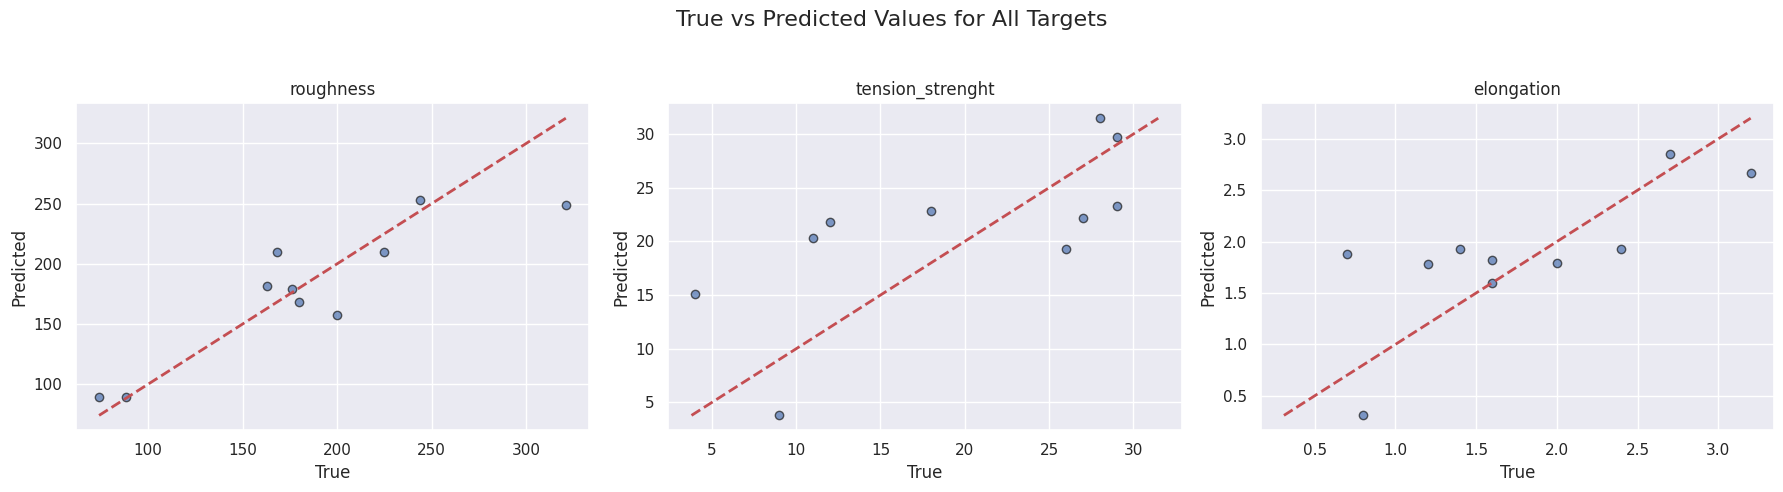

In [151]:
# IMPORT LIBRARY
import matplotlib.pyplot as plt  # Library for plotting

# PREDICT ON TEST DATA
Y_PRED = model.predict(X_TEST_SCALED)  # Predict using scaled test features

# CREATE INDIVIDUAL SCATTER PLOTS FOR EACH TARGET
TARGET_NAMES = y.columns.tolist()  # ["roughness", "tension_strenght", "elongation"]

for i, TARGET in enumerate(TARGET_NAMES):
    # CREATE FIGURE
    plt.figure(figsize=(6, 6))

    # SCATTER PLOT: True vs Predicted
    plt.scatter(y_test[TARGET], Y_PRED[:, i], alpha=0.7, edgecolors='k')

    # PLOT DIAGONAL LINE (y = x)
    min_val = min(y_test[TARGET].min(), Y_PRED[:, i].min())
    max_val = max(y_test[TARGET].max(), Y_PRED[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    # LABELS AND TITLE
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{TARGET} - True vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# STEP 7 - OPTIONAL: PLOT ALL IN ONE FIGURE WITH SUBPLOTS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # One row, three plots

for i, TARGET in enumerate(TARGET_NAMES):
    axes[i].scatter(y_test[TARGET], Y_PRED[:, i], alpha=0.7, edgecolors='k')
    min_val = min(y_test[TARGET].min(), Y_PRED[:, i].min())
    max_val = max(y_test[TARGET].max(), Y_PRED[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[i].set_xlabel("True")
    axes[i].set_ylabel("Predicted")
    axes[i].set_title(f"{TARGET}")
    axes[i].grid(True)

plt.suptitle("True vs Predicted Values for All Targets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

STEP 8 : SAVE MODEL AND SCALER

In [152]:
# SAVE THE TRAINED MODEL TO DISK
joblib.dump(MODEL, "/content/roughness_model.pkl")

# SAVE THE SCALER TO DISK
joblib.dump(SCALER, "/content/roughness_scaler.pkl")

# PRINT CONFIRMATION
print("MULTI-OUTPUT MODEL TRAINED & SAVED SUCCESSFULLY")


MULTI-OUTPUT MODEL TRAINED & SAVED SUCCESSFULLY


# USER INTERFACE

STEP 9 : USER INTERFACE FOR PREDICTIONS

In [139]:
# IMPORT UI LIBRARIES
import ipywidgets as widgets
from IPython.display import display, clear_output

# LOAD MODEL, SCALER, AND FEATURE LIST
MODEL = joblib.load("/content/roughness_model.pkl")
SCALER = joblib.load("/content/roughness_scaler.pkl")
FEATURES = joblib.load("/content/feature_columns.pkl")

DEFINE INPUT DEFAULTS AND WIDGETS

In [140]:
# DEFINE DEFAULT VALUES FOR USER INPUTS
DEFAULT_INPUTS = {
    "temperature": 220,
    "speed": 50,
    "layer_height": 0.2,
    "infill_density": 20,
    "material": "PLA",
    "infill_pattern": "grid"
}

CREATE WIDGETS FOR EACH INPUT

In [141]:
INPUT_WIDGETS = {
    "temperature": widgets.FloatText(value=DEFAULT_INPUTS["temperature"], description="Temperature:"),
    "speed": widgets.FloatText(value=DEFAULT_INPUTS["speed"], description="Speed:"),
    "layer_height": widgets.FloatText(value=DEFAULT_INPUTS["layer_height"], description="Layer Height:"),
    "infill_density": widgets.FloatText(value=DEFAULT_INPUTS["infill_density"], description="Infill %:"),
    "material": widgets.Dropdown(options=["PLA", "ABS"], value="PLA", description="Material:"),
    "infill_pattern": widgets.Dropdown(options=["grid", "lines", "triangles"], value="grid", description="Pattern:")
}


DEFINE OUTPUT SELECTION CHECKBOXES

In [142]:
# CREATE CHECKBOXES TO SELECT DESIRED PREDICTIONS
ROUGHNESS_CB = widgets.Checkbox(value=True, description="Roughness")
ELONGATION_CB = widgets.Checkbox(value=False, description="Elongation")
TENSILE_CB = widgets.Checkbox(value=False, description="Tensile Strength")

# CREATE CHECKBOX FOR SAVE OPTION
SAVE_CB = widgets.Checkbox(value=False, description="Save to CSV")


DEFINE PREDICTION CALLBACK FUNCTION

In [143]:
def predict_callback(btn):
    clear_output(wait=True)
    display(UI)

    # READ INPUT VALUES FROM WIDGETS
    ROW = {k: w.value for k, w in INPUT_WIDGETS.items()}
    DF = pd.DataFrame([ROW])

    # APPLY ONE-HOT ENCODING TO MATCH TRAINING FORMAT
    DF = pd.get_dummies(DF, columns=["material", "infill_pattern"])

    # FILL ANY MISSING COLUMNS WITH 0
    for col in FEATURES:
        if col not in DF.columns:
            DF[col] = 0
    DF = DF[FEATURES]

    # SCALE THE INPUT VALUES
    X_SCALED = SCALER.transform(DF)

    # PERFORM PREDICTION
    PREDICTION = MODEL.predict(X_SCALED)[0]

    # DEFINE LABELS AND CHECKBOXES
    OUTPUTS = ["Roughness", "Elongation", "Tensile Strength"]
    CHECKBOXES = [ROUGHNESS_CB, ELONGATION_CB, TENSILE_CB]

    RESULT = {}
    for i, (check, out) in enumerate(zip(CHECKBOXES, OUTPUTS)):
        if check.value:
            val = PREDICTION[i]
            RESULT[out] = val
            print(f"{out}: {val:.2f}")
            if out == "Roughness":
                if val <= 1:
                    quality = "Excellent (mirror-like surface)"
                elif val <= 3:
                    quality = "Good"
                elif val <= 5:
                    quality = "Moderate"
                else:
                    quality = "Poor (rough surface)"
                print(f"Surface Quality: {quality}")

    # SAVE TO CSV IF CHECKED
    if SAVE_CB.value and RESULT:
        DF_SAVE = pd.DataFrame([{**ROW, **RESULT}])
        DF_SAVE.to_csv("prediction_output.csv", index=False)
        print("Saved to 'prediction_output.csv'")

BUILD UI LAYOUT

In [144]:
# CREATE PREDICT BUTTON
PREDICT_BUTTON = widgets.Button(description="Predict", button_style='success')
PREDICT_BUTTON.on_click(predict_callback)

# ARRANGE UI ELEMENTS IN A LAYOUT
UI = widgets.VBox([
    widgets.HTML("<h3>3D Printing Multi-Prediction UI</h3>"),
    *INPUT_WIDGETS.values(),
    widgets.HTML("<b>Choose outputs:</b>"),
    widgets.HBox([ROUGHNESS_CB, ELONGATION_CB, TENSILE_CB]),
    SAVE_CB,
    PREDICT_BUTTON
])

# DISPLAY THE UI
display(UI)

Roughness: -2350.44
Surface Quality: Excellent (mirror-like surface)
Elongation: 216.03
Tensile Strength: 24.69
Saved to 'prediction_output.csv'
